In [7]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

pd.set_option('display.max_columns', None)  # None zeigt alle Spalten
pd.set_option('display.max_rows', None)  # Alle Zeilen anzeigen, vorsichtig bei großen DataFrames
pd.set_option('display.width', 1000)  # Breite anpassen


In [ ]:
# Sämtliche Metriken

def load_merge_edit_data():   
    df_ids = nfl.import_ids()
    df_weekly = nfl.import_weekly_data(list(range(2018, 2025)))
    df_seasonal = nfl.import_seasonal_data(list(range(2017,2024)))
    df_schedule = nfl.import_schedules(list(range(2018, 2025)))
    df_pass_pfr = nfl.import_weekly_pfr('pass', list(range(2018, 2025)))
    df_rush_pfr = nfl.import_weekly_pfr('rush', list(range(2018, 2025)))
    df_rec_pfr = nfl.import_weekly_pfr('rec', list(range(2018, 2025)))
    df_pass_ngs = nfl.import_ngs_data('passing',list(range(2018, 2025)))
    df_rush_ngs = nfl.import_ngs_data('rushing',list(range(2018, 2025)))
    df_snap_counts = nfl.import_snap_counts(list(range(2018, 2025)))

    df_weekly = df_weekly[(df_weekly['season_type'] == 'REG') & (df_weekly['position'].isin(['QB', 'WR', 'RB', 'TE']))].reset_index()

    df_seasonal['season'] = df_seasonal['season'] + 1

    df_schedule = df_schedule[['game_id', 'home_team', 'home_score', 'away_score']].drop_duplicates()
    df_schedule['game_id'] = df_schedule['game_id'].str.replace('OAK', 'LV', regex=False) # Umzug der Oakland Raiders nach Las Vegas in der Saison 2020
    df_schedule['home_team'] = df_schedule['home_team'].str.replace('OAK', 'LV', regex=False) # Umzug der Oakland Raiders nach Las Vegas in der Saison 2020

    df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
    df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']

    df_merged = pd.melt(
        df_weekly,
        id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'sacks', 'sack_yards', 'passing_air_yards', 'passing_epa', 'pacr', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'rushing_epa', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'racr', 'wopr', 'receiving_epa', 'fantasy_points'],
        value_vars=['game_id_home_away', 'game_id_away_home'],
        var_name='game_id_type',
        value_name='game_id'
    )

    df_ids = df_ids.rename(columns={'gsis_id': 'player_id', 'pfr_id': 'pfr_player_id'})
    df_pass_ngs = df_pass_ngs.rename(columns={'player_gsis_id': 'player_id'})
    df_rush_ngs = df_rush_ngs.rename(columns={'player_gsis_id': 'player_id'})

    df_merged = pd.merge(df_merged, df_schedule, on='game_id', how='inner') # Bei ein paar Spielen: recent_team = opponent_team
    df_merged = pd.merge(df_merged, df_ids[['player_id', 'pfr_player_id', 'draft_pick', 'draft_year']], on = 'player_id', how = 'inner') # Ein paar Spieler ohne draft_year
    df_merged = pd.merge(df_merged, df_seasonal[['player_id', 'season', 'dom']], on = ['player_id', 'season'], how = 'left')
    df_merged = pd.merge(df_merged, df_pass_pfr[['pfr_player_id', 'season', 'week', 'passing_bad_throws', 'times_pressured']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rec_pfr[['pfr_player_id', 'season', 'week', 'receiving_rat']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rush_pfr[['pfr_player_id', 'season', 'week', 'rushing_broken_tackles']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_pass_ngs[['player_id', 'season', 'week', 'passer_rating', 'aggressiveness']], on = ['player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rush_ngs[['player_id', 'season', 'week', 'efficiency']], on = ['player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_snap_counts[['pfr_player_id', 'season', 'week', 'offense_snaps']], on = ['pfr_player_id', 'season', 'week'], how = 'left')

    df_merged = df_merged.drop(columns=['game_id_type', 'pfr_player_id'])

    df_merged['draft_pick'] = df_merged['draft_pick'].fillna(260)
    df_merged = df_merged.fillna(0)

    df_merged['rookie_flag'] = (df_merged['season'] == df_merged['draft_year']).astype(int)
    df_merged['last_season_data_flag'] = (df_merged['week'] < 6).astype(int)
    df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)
    df_merged['player_id'] = df_merged['player_id'].str.replace('00-00', '').astype(int)

    df_merged['turnover'] = (
        df_merged['interceptions'] +
        df_merged['sack_fumbles_lost'] +
        df_merged['rushing_fumbles_lost'] +
        df_merged['receiving_fumbles_lost']
    )

    df_merged['rushing_pts'] = (df_merged['rushing_tds'] * 6) + (df_merged['rushing_2pt_conversions'] * 2)
    df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)
    df_merged['passing_pts'] = (df_merged['passing_tds'] * 6) + (df_merged['passing_2pt_conversions'] * 2)

    df_merged['epa_total'] = df_merged['passing_epa'] + df_merged['rushing_epa'] + df_merged['receiving_epa']

    df_merged = df_merged.drop(columns=['draft_year', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 
                                        'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 
                                        'passing_2pt_conversions', 'passing_epa', 'rushing_epa', 'receiving_epa'])

    # position target-encoded
    position_means = df_merged.groupby(['position', 'season', 'week'])['fantasy_points'].mean().reset_index()
    position_means.rename(columns={'fantasy_points': 'position_encoded'}, inplace=True)
    df_merged = pd.merge(df_merged, position_means, on=['position', 'season', 'week'], how='left')

    # points_scored und points_allowed als Maßstab für Stärke eines Teams
    df_merged['recent_team_points_scored'] = df_merged.apply(lambda row: row['home_score'] if row['home'] == 1 else row['away_score'], axis=1)
    df_merged['opponent_team_points_allowed'] = df_merged['recent_team_points_scored']

    df_unique_opponent_team_points_allowed = df_merged.drop_duplicates(subset=['game_id', 'opponent_team', 'opponent_team_points_allowed'])
    df_unique_recent_team_points_scored = df_merged.drop_duplicates(subset=['game_id', 'recent_team', 'recent_team_points_scored'])

    df_unique_opponent_team_points_allowed = df_unique_opponent_team_points_allowed.sort_values(by=['opponent_team', 'season', 'week']).reset_index(drop=True)
    df_unique_recent_team_points_scored = df_unique_recent_team_points_scored.sort_values(by=['recent_team', 'season', 'week']).reset_index(drop=True)

    df_unique_opponent_team_points_allowed['ewm_opponent_team_points_allowed_l5w'] = (
        df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
        .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
        .reset_index(level=0, drop=True)
    )

    for metric in ['mean', 'median', 'std']:
            df_unique_opponent_team_points_allowed[f"{metric}_opponent_team_points_allowed_l5w"] = (
                df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
                .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    for metric in ['min', 'max']:
            df_unique_opponent_team_points_allowed[f"{metric}_opponent_team_points_allowed_l3w"] = (
                df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
                .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    df_unique_opponent_team_points_allowed = df_unique_opponent_team_points_allowed.drop(columns=['player_id', 'position', 'season', 'week', 'recent_team', 'home_team', 'completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'fantasy_points', 'home_score', 'away_score', 'draft_pick', 'dom', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'rookie_flag', 'last_season_data_flag', 'home', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts', 'epa_total', 'position_encoded', 'recent_team_points_scored', 'opponent_team_points_allowed'])
    df_merged = pd.merge(df_merged, df_unique_opponent_team_points_allowed, on=['game_id','opponent_team'], how='inner')

    df_unique_recent_team_points_scored['ewm_recent_team_points_scored_l5w'] = (
        df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
        .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
        .reset_index(level=0, drop=True)
    )

    for metric in ['mean', 'median', 'std']:
            df_unique_recent_team_points_scored[f"{metric}_recent_team_points_scored_l5w"] = (
                df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
                .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    for metric in ['min', 'max']:
            df_unique_recent_team_points_scored[f"{metric}_recent_team_points_scored_l3w"] = (
                df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
                .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    df_unique_recent_team_points_scored = df_unique_recent_team_points_scored.drop(columns=['player_id', 'position', 'season', 'week', 'opponent_team', 'home_team', 'completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'fantasy_points', 'home_score', 'away_score', 'draft_pick', 'dom', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'rookie_flag', 'last_season_data_flag', 'home', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts', 'epa_total', 'position_encoded', 'recent_team_points_scored', 'opponent_team_points_allowed'])
    df_merged = pd.merge(df_merged, df_unique_recent_team_points_scored, on=['game_id','recent_team'], how='inner')

    # Liste der Spalten mit Spielerspezifischen numerischen Daten, für die Rolling-Features erstellt werden sollen
    columns_to_roll = ['completions', 'attempts', 'passing_yards', 'sacks', 'passer_rating', 'aggressiveness', 'efficiency', 'sack_yards', 
                    'passing_air_yards', 'pacr', 'carries', 'offense_snaps', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 
                    'racr', 'wopr', 'fantasy_points', 'passing_bad_throws', 'times_pressured', 'position_encoded', 'epa_total', 'receiving_rat', 
                    'rushing_broken_tackles', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts']


    # Sortiere nach player_id, season und week
    df_merged = df_merged.sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)


    df_merged['cnt_games_over_20ffpts_l5w'] = (
        df_merged.groupby('player_id')['fantasy_points']
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: (y > 20).sum()))
        .reset_index(level=0, drop=True)
    )

    # Rolling-Features erstellen
    for col in columns_to_roll:

        feature_name_1 = f"ewm_{col}_l5w"
        df_merged[feature_name_1] = (
            df_merged.groupby('player_id')[col]
            .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
            .reset_index(level=0, drop=True)
        )

        for metric in ['mean', 'median', 'std']:
            feature_name_2 = f"{metric}_{col}_l5w"
            rolling_result_5w = (
                df_merged.groupby('player_id')[col]
                    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                    .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df_merged[feature_name_2] = rolling_result_5w

        for metric in ['max', 'min']:
            feature_name_3 = f"{metric}_{col}_l3w"
            # Berechnung der Rolling-Metrik (ohne aktuelle Woche)
            rolling_result_3w = (
                df_merged.groupby('player_id')[col]
                    .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                    .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df_merged[feature_name_3] = rolling_result_3w

    df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 
                                        'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'passing_bad_throws', 
                                        'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'turnover', 'rushing_pts', 'receiving_pts', 
                                        'passing_pts', 'home_team', 'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'game_id',
                                        'position_encoded', 'recent_team', 'opponent_team', 'position', 'epa_total', 'home_score', 'away_score',
                                        'recent_team_points_scored', 'opponent_team_points_allowed'])

    df_merged = df_merged.dropna().reset_index()

    return df_merged

df_merged = load_merge_edit_data()

Downcasting floats.


/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_3944/265557872.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_3944/265557872.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_3944/265557872.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [9]:
X_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])].drop(columns=['fantasy_points'])
y_train = df_merged[df_merged['season'].isin([2018, 2019, 2020, 2021, 2022, 2023])]['fantasy_points']

X_val = df_merged[df_merged['season']==2023].drop(columns=['fantasy_points'])
y_val = df_merged[df_merged['season']==2023]['fantasy_points']

X_test = df_merged[df_merged['season']==2024].drop(columns=['fantasy_points'])
y_test = df_merged[df_merged['season']==2024]['fantasy_points']

In [10]:
# preprocessor = ColumnTransformer(transformers=[
#     ("num", SimpleImputer(strategy="median"), X_train.columns),
# ])

# xgb = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("scaler", StandardScaler()),
#     ("feature_selection", RFE(estimator=XGBRegressor(), n_features_to_select=60, step=1, verbose=2)),
#     ("model", XGBRegressor())
# ])

# xgb_grid = {
#     "model__max_depth": [3, 6, 7, None],
#     "model__learning_rate": [0.05, 0.1, 0.3],
#     "model__n_estimators": [100, 500, 1000]
# }

# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_grid, verbose=2, cv=TimeSeriesSplit(n_splits=3))

# xgb_grid_search.fit(X_train, y_train)

# xgb_grid_search.score(X_test, y_test)

In [11]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)


In [12]:
# define a grid of hyperparameters and possible values
xgb_grid = {
    "max_depth": [3, 6, 7, None],
    "learning_rate": [0.05, 0.1, 0.3],
    "n_estimators": [100, 500, 1000]
}

gridSearch = GridSearchCV(XGBRegressor(), xgb_grid, verbose=2, cv=TimeSeriesSplit(n_splits=3))
gridSearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.5s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   2.0s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   2.5s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   2.6s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=6, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [3, 6, 7, None],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [13]:
# get the best model and fit it on the complete  set
bestModel = gridSearch.best_estimator_.fit(X_train, y_train)
bestModel.score(X_test, y_test)

0.3964378237724304

In [14]:
rfe = RFECV(bestModel, step=1, cv=TimeSeriesSplit(n_splits=5), scoring="r2")
rfe.fit(X_train, y_train)

# Ausgewählte Features anzeigen
best_features = X_train.columns[rfe.support_]
print("Ausgewählte Features:", best_features)
print(len(best_features))
print(rfe.score(X_test, y_test))

Ausgewählte Features: Index(['draft_pick', 'dom', 'mean_opponent_team_points_allowed_l5w', 'ewm_completions_l5w', 'min_attempts_l3w', 'ewm_passer_rating_l5w', 'mean_passer_rating_l5w', 'std_passer_rating_l5w', 'median_aggressiveness_l5w', 'ewm_efficiency_l5w', 'ewm_sack_yards_l5w', 'ewm_passing_air_yards_l5w', 'ewm_carries_l5w', 'mean_carries_l5w', 'std_carries_l5w', 'min_carries_l3w', 'ewm_offense_snaps_l5w', 'max_offense_snaps_l3w', 'ewm_rushing_yards_l5w', 'mean_rushing_yards_l5w', 'median_rushing_yards_l5w', 'std_rushing_yards_l5w', 'min_rushing_yards_l3w', 'ewm_targets_l5w', 'mean_receiving_yards_l5w', 'median_racr_l5w', 'max_racr_l3w', 'ewm_wopr_l5w', 'mean_wopr_l5w', 'ewm_fantasy_points_l5w', 'mean_fantasy_points_l5w', 'median_fantasy_points_l5w', 'ewm_passing_bad_throws_l5w', 'ewm_times_pressured_l5w', 'mean_times_pressured_l5w', 'ewm_position_encoded_l5w', 'mean_position_encoded_l5w', 'min_position_encoded_l3w', 'ewm_receiving_rat_l5w', 'ewm_rushing_broken_tackles_l5w', 'ewm_t

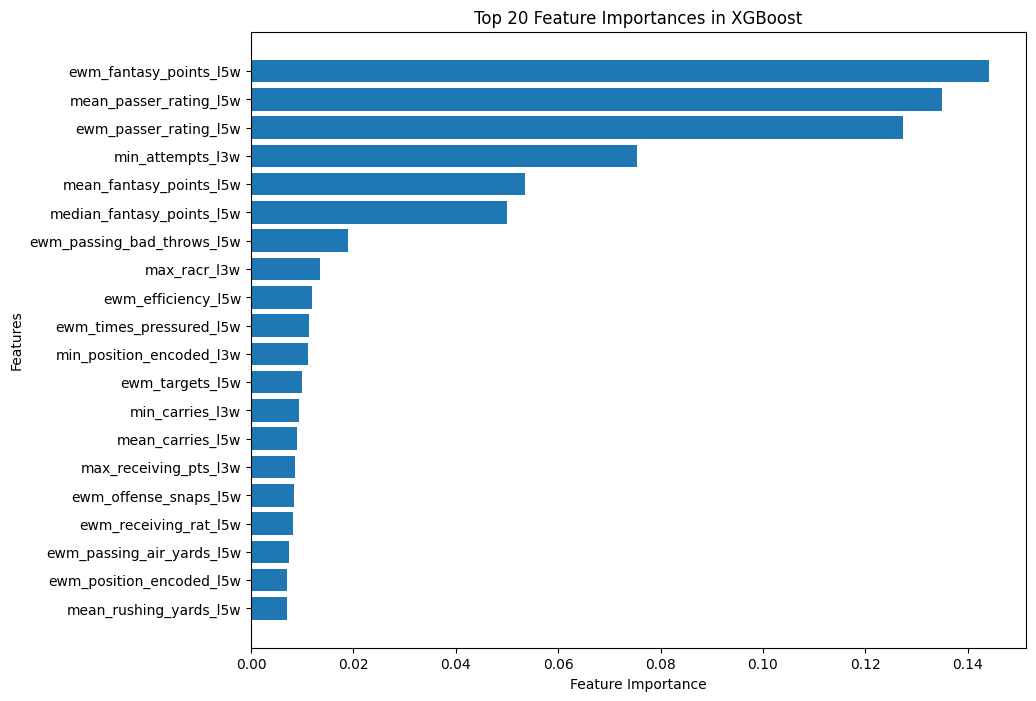

In [15]:
# Hole die Feature-Wichtigkeiten
feature_importances = bestModel.feature_importances_

# Erstelle ein DataFrame für Features und deren Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sortiere die Feature-Wichtigkeiten absteigend
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wähle die Top 20 Features
top_features = feature_importance_df.head(20)

# Plotten der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()  # Um die höchste Wichtigkeit oben anzuzeigen
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in XGBoost")
plt.show()

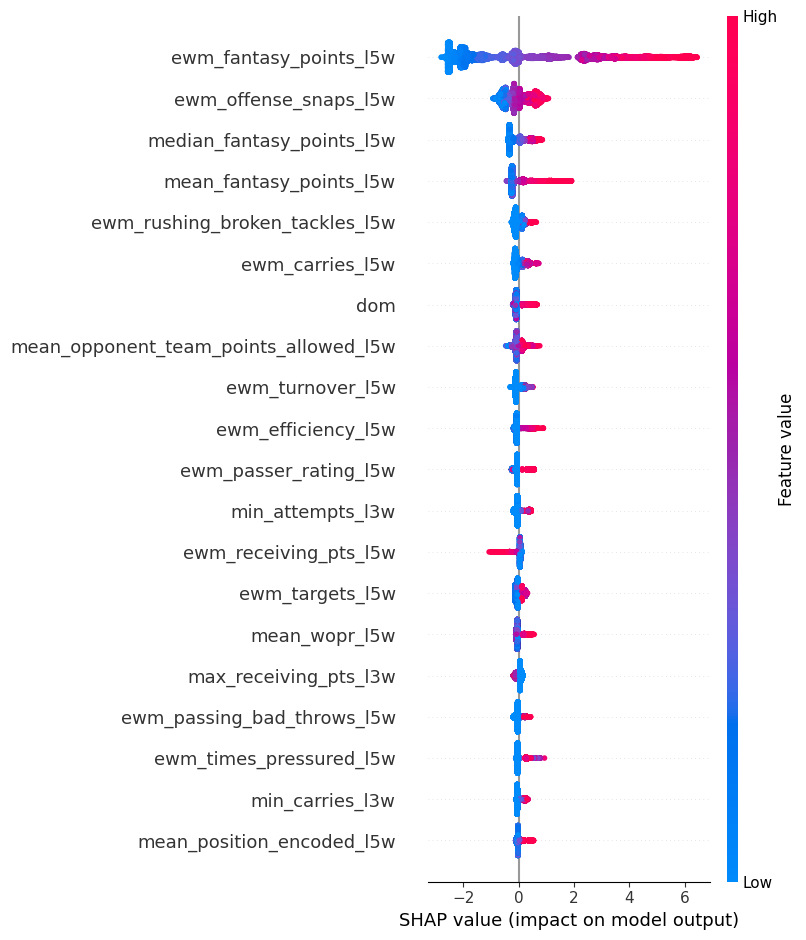

In [16]:
import shap

# Berechne SHAP-Werte
explainer = shap.TreeExplainer(bestModel)
shap_values = explainer.shap_values(X_train)

# Plot der Feature-Wichtigkeit
shap.summary_plot(shap_values, X_train)


In [17]:
# Vorhersage für 2024
y_pred_2024 = rfe.predict(X_test)

df_ids = df_ids.dropna(subset=['player_id'])
df_ids['player_id'] = df_ids['player_id'].str.replace('00-00', '').astype(int)
df_weekly['player_id'] = df_weekly['player_id'].str.replace('00-00', '').astype(int)


df_merged_2024 = pd.merge(df_merged[df_merged['season']==2024], df_ids[['name', 'player_id', 'position']], on = 'player_id', how = 'inner')
df_merged_2024 = pd.merge(df_merged_2024, df_weekly[['player_id', 'season', 'week', 'recent_team', 'opponent_team']], on = ['player_id', 'season', 'week'], how = 'inner')
df_merged_2024['predicted_fantasy_points'] = y_pred_2024

NameError: name 'df_ids' is not defined

In [14]:
print('mean absolute error: ' + str(mean_absolute_error(y_test, rfe.predict(X_test))))
print('mean squared error: ' + str(mean_squared_error(y_test, rfe.predict(X_test))))
print('root mean squared error: ' + str(root_mean_squared_error(y_test, rfe.predict(X_test))))
print('r2 score: ' + str(r2_score(y_test, rfe.predict(X_test))))


from scipy.stats import spearmanr
# Erstelle eine Rangliste basierend auf predicted und tatsächlichen Punkten und berechne die Spearman-Rangkorrelation
rank_predicted = pd.Series(rfe.predict(X_test)).rank(ascending=False)
rank_actual = pd.Series(y_test).rank(ascending=False)
spearman_corr, _ = spearmanr(rank_predicted, rank_actual)
print(f"Spearman-Rangkorrelation: {spearman_corr:.2f}")


# Spearman-Rangkorrelation nach Position und Woche
results = []
# Gruppieren nach Position und Woche
for (position, week), group in df_merged_2024.groupby(['position', 'week']):
    # Erstelle Ranglisten
    rank_predicted = group['predicted_fantasy_points'].rank(ascending=False)
    rank_actual = group['fantasy_points'].rank(ascending=False)
    
    # Berechne Spearman-Rangkorrelation
    if len(group) > 1:  # Nur berechnen, wenn mehr als 1 Spieler in der Gruppe ist
        spearman_corr, _ = spearmanr(rank_predicted, rank_actual)
        results.append({'Position': position, 'Week': week, 'Spearman Correlation': spearman_corr})
    else:
        results.append({'Position': position, 'Week': week, 'Spearman Correlation': None})  # Zu wenige Daten
df_results = pd.DataFrame(results)
print(df_results)

mean absolute error: 4.1037207
mean squared error: 31.102694
root mean squared error: 5.5769787
r2 score: 0.396820604801178
Spearman-Rangkorrelation: 0.62
   Position  Week  Spearman Correlation
0        QB     1              0.714548
1        QB     2              0.488410
2        QB     3              0.408962
3        QB     4              0.533384
4        QB     5              0.678398
5        QB     6              0.584427
6        QB     7              0.666484
7        QB     8              0.267532
8        QB     9              0.448128
9        QB    10              0.641263
10       QB    11              0.106498
11       QB    12              0.590963
12       QB    13              0.171053
13       QB    14              0.826613
14       QB    15              0.578039
15       QB    16              0.371689
16       QB    17              0.652533
17       QB    18              0.397793
18       RB     1              0.599761
19       RB     2              0.762618
20   

In [15]:
# CSV-Datei mit den notwendigen Spalten
df_output = df_merged_2024[['player_id', 'name', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'predicted_fantasy_points', 'fantasy_points']]
df_output.to_csv('fantasy_points_predictions_2024.csv', index=False)